Model evaluation, model selection and hyperparameter tuning in both a regression and classification setting.

Environment Setup

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Part 1: Regression

Try to predict a real value home sale price using several models.

       SqFtLiving1e3  SqFtLot1e3  NumBedrooms
count         500.00      500.00       500.00
mean            1.90        5.79         3.26
std             0.75        2.38         0.87
min             0.66        0.97         1.00
25%             1.33        4.00         3.00
50%             1.79        5.70         3.00
75%             2.36        7.75         4.00
max             4.20        9.99         7.00


<Axes: xlabel='SalePrice1e5', ylabel='Count'>

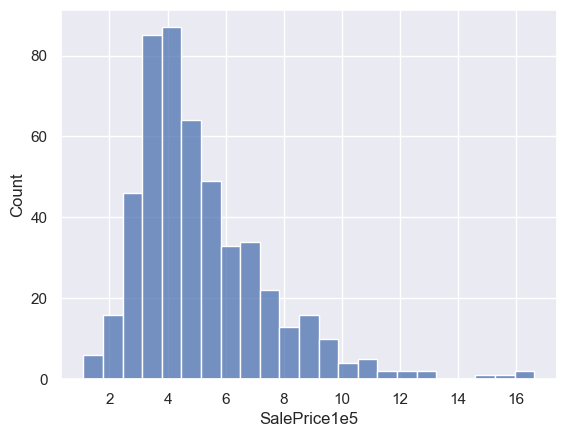

In [3]:

# Read in the csv file ../data/home_sales.csv 
# Store in df
df = pd.read_csv('../data/home_sales.csv')

X = df[['SqFtLiving1e3', 'SqFtLot1e3', 'NumBedrooms']]

# Create a series y_r which contains only the column SalePrice1e5
y_r = df['SalePrice1e5']

# Check that X and y_r are the correct shape (500 rows)
assert X.shape == (500,3)
assert y_r.shape == (500,)

# To confirm that all features of X are similar in scale display the .describe() of X
#   Use .round(2) to round all values to a precision of 2
print(X.describe().round(2))

# To get a sense of the distribution of the target, plot a histogram of y_r using sns.histplot()
sns.histplot(y_r)

In [4]:
#Create a training and test/held-aside set for regression

# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split X and y_r using train_test_split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_r, test_size=0.2, random_state=512)

proportion of data in test set: 0.2


### Part 1.1 Baseline Regressor

In [5]:
Create a DummyRegressor and fit on the training set.

# Import the DummyRegressor model from sklearn 
from sklearn.dummy import DummyRegressor

# Instantiate a DummyRegessor model with strategy="mean" (the default)
# Store in dummy_r
dummy_r = DummyRegressor()

# Train the DummyRegressor on the regression training set
dummy_r.fit(X_train_r, y_train_r)

# Calculate the training set R^2 score of the DummyRegressor
dummy_r_training_r2 = dummy_r.score(X_train_r, y_train_r)

# Recall that this should equal 0
print(f'dummy training set R^2: {dummy_r_training_r2.round(2)}')

dummy training set R^2: 0.0


### Part 1.2 Linear Regression and Cross-Validation

In [6]:
#Train a Linear Regression model and calculate training set R^2.

# Import the LinearRegression model from sklearn
from sklearn.linear_model import LinearRegression

# Instantiate a LinearRegression model Store in lr
lr = LinearRegression().fit(X_train_r, y_train_r)

# Calculate the training set R^2 of the LinearRegression model
lr_training_r2 = lr.score(X_train_r, y_train_r)

# This should be better than our dummy R^2
print(f'lr training set R^2: {lr_training_r2.round(2)}')

lr training set R^2: 0.49


In [7]:
#   Use 5-fold Cross Validation to get a sense of the variation 
#    of Liner Regression R^2 performance on the training set.

# Import cross_val_score from sklearn.
from sklearn.model_selection import cross_val_score

# Generate 5-fold cross-validation R^2 scores 
# Store in lr_cv_scores
lr_cv_scores = cross_val_score(LinearRegression(), X_train_r, y_train_r, cv=5)

# Print out the R^2 scores found by cross_val_score rounded to a precision of 2
lr_cv_scores.round(2) 

array([0.5 , 0.51, 0.48, 0.34, 0.44])

In [8]:
#Calculate mean training cv R^2 score +- 2 std. deviations

# Calculate the mean training cross validation score using the scores created above
lr_cv_mean = lr_cv_scores.mean()

# Calculate 2 standard deviations of the cross validation scores
lr_cv_2std = lr_cv_scores.std() * 2

# Print out the mean R^2 +- 2 standard variations for the LinearRegression model
#   each rounded to a precision of 2
print(f'lr mean cv r2: {lr_cv_mean.round(2)} +- {lr_cv_2std.round(2)}')

lr mean cv r2: 0.45 +- 0.12


### Part 1.3 Overfitting with a Decision Tree

In [9]:
#  Create a DecisionTreeRegressor and fit on the training set.

# Import the DecisionTreeRegressor model from sklearn 
from sklearn.tree import DecisionTreeRegressor

# Instantiate a DecisionTreeRegressor model 
#    with max_depth=10
#    and fit on the training set
# Store in dtr
dtr = DecisionTreeRegressor(max_depth=10).fit(X_train_r, y_train_r)

# Calculate the training set R^2 score of the DecisionTreeRegressor
dtr_training_r2 = dtr.score(X_train_r, y_train_r)

# This should be a high R^2 value
print(f'dummy training set R^2: {dtr_training_r2.round(2)}')

dummy training set R^2: 0.95


### Part 1.3 Evaluate on Test Set

In [10]:
# Evaluate performance of our trained models on the test set.

# Calculate R^2 on the test set using the previously trained models
dummy_r_test_r2 = dummy_r.score(X_test_r, y_test_r)

lr_test_r2 = lr.score(X_test_r, y_test_r)

dtr_test_r2 = dtr.score(X_test_r, y_test_r)

print(f'dummy test R2 : {dummy_r_test_r2.round(2): .2f}') # this may be less than 0
print(f'   lr test R2 : {lr_test_r2.round(2): .2f}')      # this should within the lr training cv += 2 std devs
print(f'  dtr test R2 : {dtr_test_r2.round(2): .2f}')     # this should show overfitting

dummy test R2 : -0.01
   lr test R2 :  0.39
  dtr test R2 : -0.07


---

## Part 2: Classification

Here we build several models to classify low vs. high sale price, create a validation curve and perform grid search.

### Create Classification Target

In [11]:
# To reuse the same dataset, we'll first create a binary target for 
#    classification by thresholding at the mean of our SalePrice1e5

# The classes are:
#    Low  SalePrice1e5 = 0
#    High SalePrice1e5 = 1

y_c = (df.SalePrice1e5 > df.SalePrice1e5.mean()).astype(int)

# Print out the class labels with count
pd.Series(y_c).value_counts()

0    305
1    195
Name: SalePrice1e5, dtype: int64

### Part 2.1 Create Classification Train/Test Split

In [12]:
#Create a training and test/held-aside set for classifiction

# Split X (the same X as before) and the new y_c using train_test_split
#   Stratify according to y_c so class proportions are the same in train and test
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_c, test_size=0.2, stratify=y_c, random_state=512)

proportion_low_values = (y_c == 0).mean()
print(f'proportion of Low values: {proportion_low_values.round(2)}') # should be near 60%

proportion_low_train = (y_train_c == 0).mean()
proportion_low_test = (y_test_c == 0).mean()

# Assert that train and test have similar class proportions.
assert abs(proportion_low_train - proportion_low_test) < 0.01

proportion of Low values: 0.61


### Part 2.2 Measure Classification Baseline Performance

In [13]:
# Create a Dummy Classifier and confirm the expected performance on the training set.

# Import DummyClassifier from sklearn
from sklearn.dummy import DummyClassifier

# Instantiate a DummyClassifier with strategy="prior" (default) 
dummy_c = DummyClassifier().fit(X_train_c, y_train_c)

# Print the trained DummyClassifier accuracy on the training set rounded to a precision of 2
#   It should match the proportion of Low values we saw above.
print(f'dummy training set accuracy: {dummy_c.score(X_train_c, y_train_c).round(2)}')

dummy training set accuracy: 0.61


### Part 2.3  Logistic Regression model

In [14]:
#     It's good practice to start with a "simple" model.
#     Train and calculate 5-fold cv training set accuracy for a Logistic Regression Classifier.

# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Generate 5-fold cross validation accuracy on the training set
logr_cv_scores = cross_val_score(LogisticRegression(), X_train_c, y_train_c, cv=5)

# Print out the mean cv accuracy for the LogisticRegression model rounded to a precision of 2
print(f'logr mean cv accuracy: {logr_cv_scores.mean().round(2)}')

logr mean cv accuracy: 0.78


### Part 2.4 GradientBoosting model

In [15]:
#     Train and calculate 5-fold cv accuracy 
#     for a GradientBoosting model using the training set.

# Import the GradientBoostingClassifier model from sklearn
from sklearn.ensemble import GradientBoostingClassifier

# Calculate 5-fold cv training set accuracy scores 
# This time call cross_val_score with n_jobs=-1 (use one core for each fold) to speed up the cv calculations
gbc_cv_scores = cross_val_score(GradientBoostingClassifier(n_estimators=50, max_depth=10), X_train_c, y_train_c, cv=5, n_jobs=-1)
 
print(f'gbc mean cv accuracy: {gbc_cv_scores.mean().round(2)}')

gbc mean cv accuracy: 0.72


### Part 2.5 GradientBoosting and Validation Curve

In [16]:
#     Generate a validation curve for tree depths in the GradientBoosting model.

# Import the validation_curve function from sklearn
from sklearn.model_selection import validation_curve

# In the GradientBoostingClassifier model, the depth of trees is set via max_depth
# Create a list depths that contains the values 1,2,3,5,10
depths = [1, 2, 3, 5, 10]

# Generate the train_scores and test_scores for max_depth at different maximum depths
# Store the results in train_scores,test_scores
train_scores, test_scores = validation_curve(GradientBoostingClassifier(n_estimators=50), X_train_c, y_train_c, param_name='max_depth', param_range=depths, cv=3, n_jobs=-1)

train_scores.round(2)

array([[0.79, 0.81, 0.8 ],
       [0.83, 0.86, 0.84],
       [0.91, 0.92, 0.91],
       [0.99, 0.99, 1.  ],
       [1.  , 1.  , 1.  ]])

,mean_train_scores,mean_test_scores
1,0.80,0.76
2,0.85,0.79
3,0.91,0.77
5,0.99,0.77
10,1.00,0.72


Text(0, 0.5, 'mean accuracy')

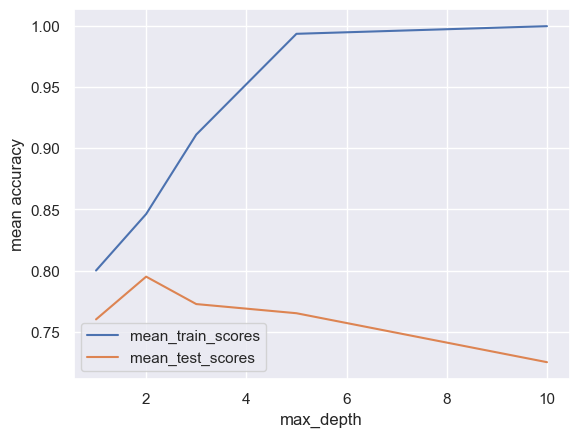

In [17]:
#  Plot the validation curves generated above

# train_scores and test_scores each contain a 2-D array of values
mean_train_scores = train_scores.mean(axis=1)
mean_test_scores = test_scores.mean(axis=1)

assert mean_train_scores.shape == (5,) # There should now be 5 floats, one per row, and no columns
assert mean_test_scores.shape == (5,)

# Store in df_val_scores
df_val_scores = pd.DataFrame({'mean_train_scores': mean_train_scores, 'mean_test_scores': mean_test_scores}, index=depths)

# Display df_val_scores with values rounded to a precision of 2
display(df_val_scores.round(2))

# Plot the values in df_val_scores 
ax = df_val_scores.plot(kind='line')
ax.set_xlabel("max_depth")
ax.set_ylabel("mean accuracy")

### Part 2.6 GradientBoosting and Grid Search

In [18]:
#     Now let's tune two hyperparameters at the same time.
#     Perform 3-fold cross validated grid search over "number of trees" and "tree depth".

from sklearn.model_selection import GridSearchCV

# Create the grid of parameters to test as a dictionary
param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [1, 2, 3, 5, 10]}

# Instantiate and fit GridSearchCV on the classification training set
gbc_gscv = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=3, n_jobs=-1).fit(X_train_c, y_train_c)

# Print out the best the best hyperparameter setting found (best_params_) 
#    and the mean accuracy they produced (best_score_)
print(f'gbc best hyperparams      : {gbc_gscv.best_params_}')
print(f'gbc best mean cv accuracy : {gbc_gscv.best_score_}')


gbc best hyperparams      : {'max_depth': 1, 'n_estimators': 200}
gbc best mean cv accuracy : 0.797534881981072


### Part 2.7 Evaluate on Test

In [19]:

print('best model found: logr test')

# To see how each of our models would generalize to new data, calculate the **test set** accuracy for each of our trained models


logr = LogisticRegression().fit(X_train_c, y_train_c)

# Find the test set accuracy of both of our trained models
logr_test_acc = logr.score(X_test_c, y_test_c)
gbc_test_acc = gbc_gscv.score(X_test_c, y_test_c)


print(f'logr test acc     : {logr_test_acc.round(2)}')
print(f'gbc_gscv test acc : {gbc_test_acc.round(2)}')

best model found: ____
logr test acc     : 0.77
gbc_gscv test acc : 0.76
